In [99]:
import numpy as np
import pandas as pd

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
#from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import fbeta_score,accuracy_score

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns


#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [83]:
# Load the Census dataset
trainData=pd.read_csv("census.csv")
trainData.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


# Explore Data

In [84]:
trainData.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [85]:
#Number of rows and columns
trainData.shape

(45222, 14)

In [86]:
def getUniqueValues(df,colName):
    print("Number of unique values for {:} = {:}".format(colName,df[colName].nunique()))
    print("Unique values for {:} = {:}".format(colName,df[colName].unique()))

getUniqueValues(data,"workclass")
getUniqueValues(data,"education_level")
getUniqueValues(data,"relationship")

Number of unique values for workclass = 7
Unique values for workclass = [' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' Self-emp-inc' ' Without-pay']
Number of unique values for education_level = 16
Unique values for education_level = [' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' 7th-8th' ' Doctorate' ' Assoc-voc' ' Prof-school'
 ' 5th-6th' ' 10th' ' Preschool' ' 12th' ' 1st-4th']
Number of unique values for relationship = 6
Unique values for relationship = [' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative']


In [87]:
#Total number of records
n_records = trainData.shape[0]

#Number of records where individual's income is more than $50,000
n_greater_50k = len(trainData[trainData['income']=='>50K'])

#Number of records where individual's income is at most $50,000
n_at_most_50k = len(trainData[trainData['income']=='<=50K'])

#Percentage of individuals whose income is more than $50,000
greater_percent = len(trainData[trainData['income']=='>50K'])/len(data)

print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 0.2478439697492371%


Skew for  age 0.5328158942555792
Skew for  capital-gain 11.789002180291192
Skew for  capital-loss 4.516304152981587
Skew for  hours-per-week 0.34054514378520867
Skew for  education-num -0.3106209464770189


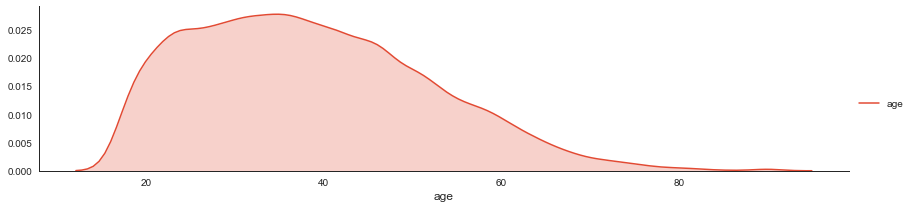

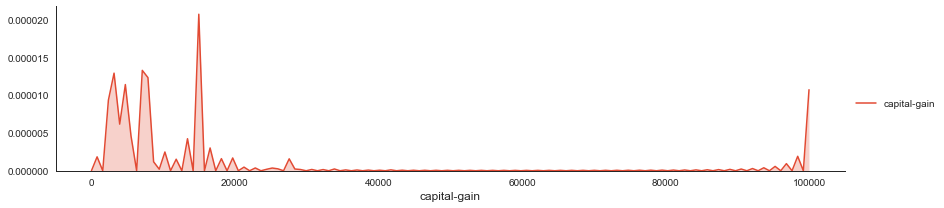

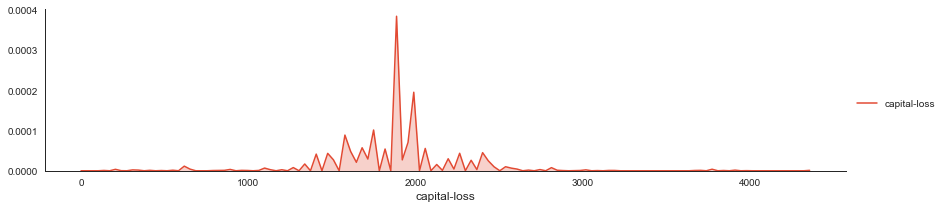

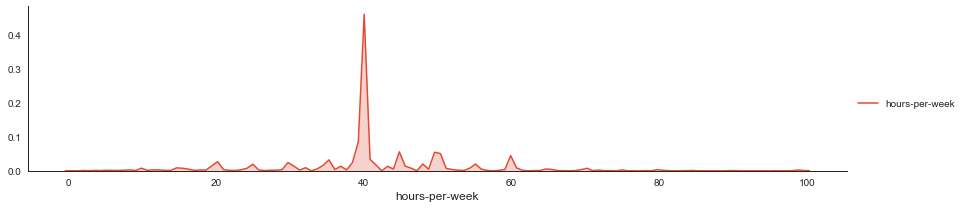

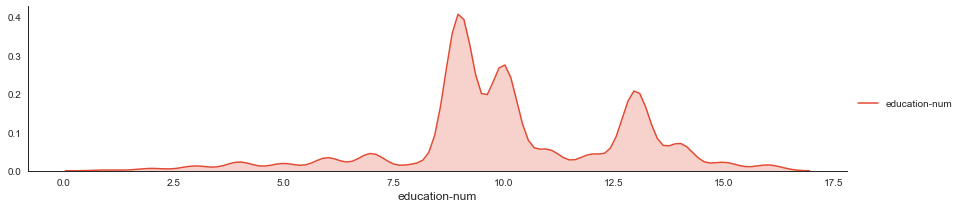

In [88]:
categorical = ['workclass', 'education_level', 'marital-status', 'occupation', 'relationship', 
               'race', 'sex', 'native-country']
continues = ['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'education-num']

# plot disctribution and check skewness:
for column in continues:
    a = sns.FacetGrid(trainData, aspect=4 )
    a.map(sns.kdeplot, column, shade= True )
    a.add_legend()
    print('Skew for ',str(column), trainData[column].skew())

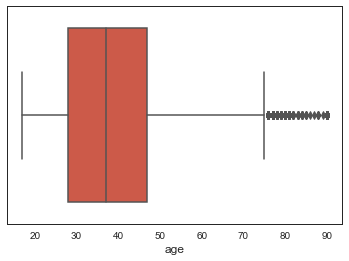

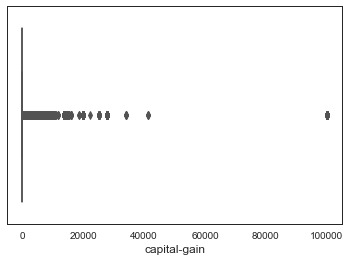

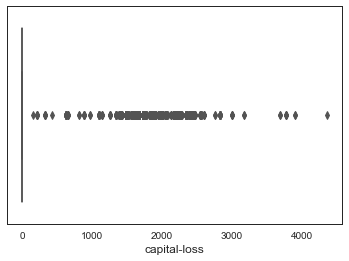

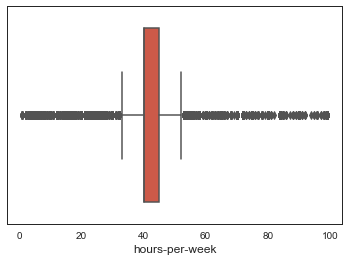

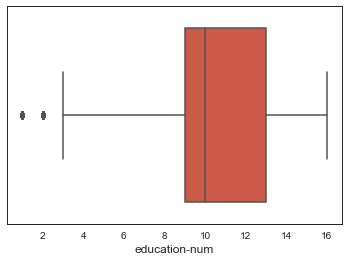

In [89]:
#check for outliers
for column in continues:
    sns.boxplot(trainData[column])
    plt.show()

# PreProcessing 

In [90]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler
def preprocessData(df):
    # Log-transform the skewed features
    skewed = ['capital-gain', 'capital-loss']
    features_log_transformed = pd.DataFrame(data = df)
    features_log_transformed[skewed] = df[skewed].apply(lambda x: np.log(x + 1))
    
    #Normalize numerical features
    # Initialize a scaler, then apply it to the features
    scaler = MinMaxScaler() # default=(0, 1)
    numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

    features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
    features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])
    
    # One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
    features_final = pd.get_dummies (features_log_minmax_transform)
    return features_final

In [91]:
# Split the data into features and target label
trainData['income']= trainData['income'].apply(lambda x: 1 if x ==">50K" else 0)
features_raw = trainData.drop('income', axis = 1)

#runing a function to receive processed data
features_final = preprocessData(features_raw)

#event_dictionary={">50K":1,"<=50K":0}
#income = incomeData.map(event_dictionary)
# income = income_raw.apply(lambda x: 1 if x ==">50K" else 0)
income=trainData['income']
# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print ("{} total features after one-hot encoding.".format(len(encoded)))


103 total features after one-hot encoding.


In [92]:
features_final.head(1)

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0.30137,0.8,0.667492,0.0,0.397959,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [93]:
#Show relation between independant variables and income
trainDataColumns=trainData.columns.tolist()
for independantVariable in trainDataColumns:
    if trainData[independantVariable].dtype == 'object' :
        print(trainData[['income',independantVariable]].groupby(independantVariable).mean())
        print('-'*20)

                     income
workclass                  
 Federal-gov       0.390469
 Local-gov         0.295161
 Private           0.217702
 Self-emp-inc      0.554070
 Self-emp-not-inc  0.278978
 State-gov         0.267215
 Without-pay       0.095238
--------------------
                   income
education_level          
 10th            0.067048
 11th            0.054972
 12th            0.074523
 1st-4th         0.036036
 5th-6th         0.048998
 7th-8th         0.066829
 9th             0.056213
 Assoc-acdm      0.264101
 Assoc-voc       0.257274
 Bachelors       0.419815
 Doctorate       0.733456
 HS-grad         0.163431
 Masters         0.554097
 Preschool       0.013889
 Prof-school     0.754140
 Some-college    0.201030
--------------------
                          income
marital-status                  
 Divorced               0.104018
 Married-AF-spouse      0.437500
 Married-civ-spouse     0.454239
 Married-spouse-absent  0.097826
 Never-married          0.048020
 Separa

Shuffle and Split Data

In [94]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


Train Model

In [ ]:

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    #Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    print(1111)
    #Calculate the training time
    results['train_time'] = end-start
        
    #Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)

    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    print(1111)
    #Calculate the total prediction time
    results['pred_time'] = end-start
            
    #Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    #Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
        
    
    #Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,beta=0.5)
        
    #Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test,predictions_test,beta=0.5)
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [ ]:
machineLearningClassifiers = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    #XGBClassifier()    
    ]



In [ ]:
# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data

samples_1 = int(0.01*len(X_train))
samples_10 = int(0.1*len(X_train))
samples_100 = len(X_train)

# Collect results on the learners
results = {}
for clf in machineLearningClassifiers:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen


In [ ]:
classifierName=[]
trainAccuracy=[]
testAccuracy=[]
results = {}
for clf in machineLearningClassifiers:
    clf_name = clf.__class__.__name__
    results[clf_name] = train_predict(clf, len(X_train), X_train, y_train, X_test, y_test)
    classifierName.append(clf_name)
    trainAccuracy.append(results[clf_name]["acc_train"])
    testAccuracy.append(results[clf_name]["acc_test"])
    


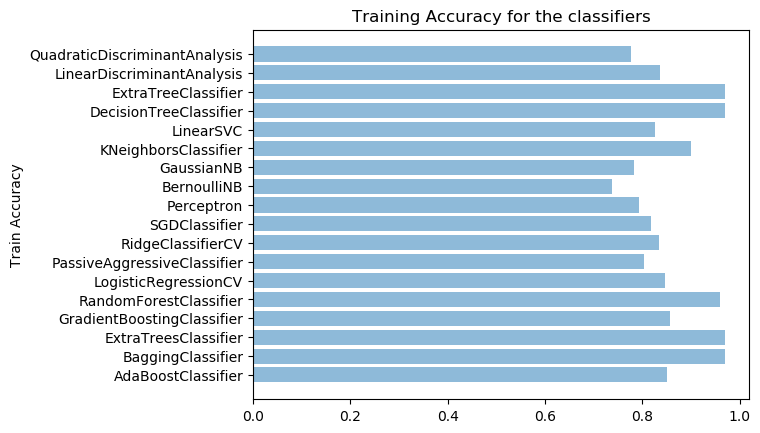

In [71]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

plt.barh(classifierName,trainAccuracy,align='center', alpha=0.5)
#plt.yticks(trainAccuracy,classifierName)
plt.ylabel('Train Accuracy')
plt.title('Training Accuracy for the classifiers')

plt.show()


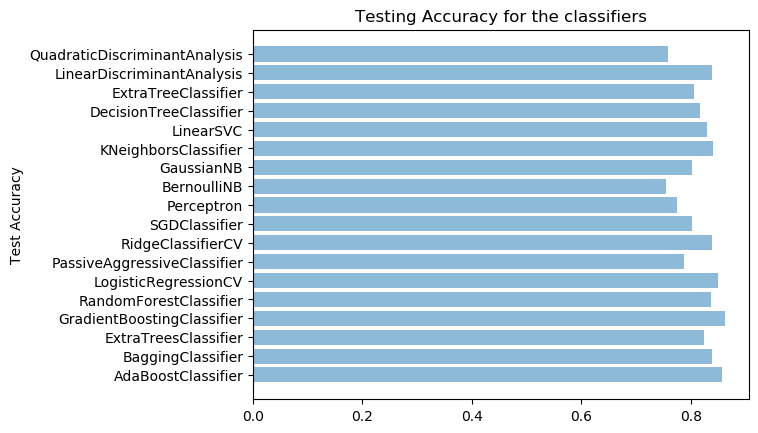

In [72]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

plt.barh(classifierName,testAccuracy,align='center', alpha=0.5)
#plt.yticks(trainAccuracy,classifierName)
plt.ylabel('Test Accuracy')
plt.title('Testing Accuracy for the classifiers')

plt.show()


Tuning Best Model

In [132]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,fbeta_score,roc_auc_score
#Initialize the classifier
clf = ensemble.GradientBoostingClassifier()


#Create the parameters list you wish to tune
random_state=[0,10,20,30,40,50]
learning_rate= [0.001, 0.01, 0.1, 1]
n_estimators = [100,200]
max_depth=[3,5,7,9]
min_samples_split=[2,3,5,7,9]
min_samples_leaf=[1,3,5,7]
# parameters= {'penalty':penalty,'C':C}
parameters= {"learning_rate":learning_rate,"n_estimators":n_estimators,"max_depth":max_depth,"min_samples_split":min_samples_split,"min_samples_leaf":min_samples_leaf}

scorer = make_scorer(roc_auc_score)

#Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scorer)
#Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print ("Unoptimized model\n------")
print ("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print ("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print ("\nOptimized Model\n------")
print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print ("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Administrator\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-132-39db67a37df7>", line 22, in <module>
    grid_fit = grid_obj.fit(X_train,y_train)
  File "C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 688, in fit
    self._run_search(evaluate_candidates)
  File "C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 1149, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 667, in evaluate_candidates
    cv.split(X, y, groups)))
  File "C:\Users\Administrator\Anaconda3\lib\site-packages\joblib\parallel.py", line 924, in __call__
    while self.dispatch_one_batch(iterator):
  File "C:\Users\Administrator\Anaconda3\lib\si

KeyboardInterrupt: 

In [101]:
testData = pd.read_csv("test_census.csv")
testData.head(1)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,21.0,Private,10th,6.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40.0,United-States


In [102]:
#Fill Missing Values
print(testData.isnull().values.any())
# Total missing values for each feature
print(testData.isnull().sum())

True
age                17
workclass          22
education_level    20
education-num      14
marital-status     21
occupation         22
relationship       16
race               19
sex                19
capital-gain       15
capital-loss       17
hours-per-week     13
native-country     16
dtype: int64


In [103]:
def fillMissingValues(df):
    colNames=list(df.columns.values)
    for colName in colNames:
        if df[colName].dtypes==float or df[colName].dtypes==int:
            median = df[colName].median()
            df[colName].fillna(median, inplace=True)
        else:
            mode = df[colName].mode()[0]
            df[colName].fillna(mode, inplace=True)

In [104]:
fillMissingValues(testData)

In [105]:
#Fill Missing Values
print(testData.isnull().values.any())
# Total missing values for each feature
print(testData.isnull().sum())

False
age                0
workclass          0
education_level    0
education-num      0
marital-status     0
occupation         0
relationship       0
race               0
sex                0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
dtype: int64


In [119]:
features_final = preprocessData(testData)

In [133]:
clf=ensemble.GradientBoostingClassifier(random_state = 42, subsample = 0.8, min_samples_leaf = 50, max_depth = 6, min_samples_split = 200, n_estimators = 180, learning_rate = 0.1 )
#clf=ensemble.AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0, n_estimators=300, random_state=None)
clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=300, random_state=None)

In [127]:
pred1=clf.predict(features_final)

pred

array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

In [128]:
ids=list(range(0,len(pred)))
len(ids)

45222

In [129]:
d = {'id': ids, 'income': pred}
df = pd.DataFrame(data=d)

In [130]:
df.to_csv("submissionOutput.csv",index=False) 